# Music Recommendation System
$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

In this project, we build a music recommendation system based on the listening records of users and users' interactions. The goal is to provide each user a ranked list of recommended artists that he/she might like. Two main methods for the recommendation system are:
<ul>
  <li> <b>Collaborative Filtering:</b>  Recommend the favorite artists of those who are friends of the user. This assumes that users who have connected on the music platform have the same taste of music. No advanced algorithms will be used. Accuracy will be tested on how similiar the recommended artists list is to the list of artists that a user has actually listened to.
  <li> <b>Content Based:</b>  Extract information on a user's favorite artists to recommend similar artists to the user. We will separate users' favorite artists into a training set and a test set. The algorithm to be used is matrix decomposition and Stochastic Gradient Descent(SGD). Accuracy will be tested on if the recommmended artists list match the list in the test set for each user.
</ul>
</div>
<br/>
<div class="span5 alert alert-success">

</div>


In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Data Preprocessing

Import relevant modules and read datasets. The rates are generated from the artists' played frequencies. We devide the rates by 10000 so that huge numeric numbers will not appear when  matrix operations are performed.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
user_artists = pd.read_table('gdrive/My Drive/Project2/hetrec2011-lastfm-2k/user_artists.dat', sep='\t', header=None, skiprows=1)
user_artists = user_artists.rename(index = int, columns={0: "UserID", 1: "ArtistID", 2: "Rate"})
user_artists.Rate = user_artists.Rate/10000
user_artists.head()

,UserID,ArtistID,Rate
0,2,51,1.3883
1,2,52,1.1690
2,2,53,1.1351
3,2,54,1.0300
4,2,55,0.8983


Store the user list and the artist list.

In [0]:
user_list = user_artists.UserID.unique()
artist_list = user_artists.ArtistID.unique()

Store pairs of (UserID, ArtistID) in a new column called UA.

In [4]:
user_artists_no_rate = user_artists.drop(columns=['Rate'])
user_artists['UA']= list(zip(user_artists_no_rate.UserID, user_artists_no_rate.ArtistID))
user_artists.head()

,UserID,ArtistID,Rate,UA
0,2,51,1.3883,"(2, 51)"
1,2,52,1.1690,"(2, 52)"
2,2,53,1.1351,"(2, 53)"
3,2,54,1.0300,"(2, 54)"
4,2,55,0.8983,"(2, 55)"


Next, we check if the user_artists data set is balanced.

In [5]:
user_artists.UserID.value_counts().head(20)

2047    50
1749    50
917     50
981     50
1109    50
1173    50
1237    50
1301    50
1365    50
1429    50
1493    50
1557    50
1621    50
1685    50
1813    50
792     50
1877    50
1941    50
2005    50
22      50
Name: UserID, dtype: int64

It seems most users have 50 favorite artists. We will check which users do not have 50 records in the user_artists dataframe. They will be considered as outliers. 63 users belong to this category.

Let us check if any user has >50 records. The answer is no.

In [6]:
user_counts = user_artists.groupby(['UserID']).count()[['ArtistID']]
user_counts.columns = ['Counts']
user_counts.loc[user_counts.Counts > 50]

,Counts
UserID,


We will delete the users that have <50 records.

Store the list of users that have less than 50 favorite artists.

In [0]:
minors = list(user_counts.loc[user_counts.Counts < 50].reset_index().UserID)

We will see that we do not miss much data if the users that have less than 50 artists are delelted.

In [8]:
len(user_artists.loc[user_artists.UserID.isin(minors)])

1384

In [9]:
len(user_artists.loc[~user_artists.UserID.isin(minors)])

91450

In [10]:
len(user_artists)

92834

In [11]:
len(user_artists.loc[~user_artists.UserID.isin(minors)])/len(user_artists)

0.9850916690005816

The new dataframe "user_ artists_majority" has the property that each user has 50 favorite artists. Throughout this project, we will use the dataframe "user_ artists_majority" for the conformity that each user has 50 favorite artists.

In [0]:
user_artists_majority = user_artists.loc[~user_artists.UserID.isin(minors)]

## Preliminary Data Analysis

We will check which artists are most popular by counting their hitting times by users.

In [23]:
pd.DataFrame(user_artists_majority.groupby(['ArtistID']).Rate.sum()*10000).rename(columns={'Rate':'HitTimes'}).head(50)

,HitTimes
ArtistID,
1,771.0
2,8012.0
3,775.0
4,562.0
5,913.0
6,5080.0
7,95884.0
8,10791.0
9,9621.0


It seems like artists 51 and 55 are quite popular.

We will visualize the popularity of the artists.

In [0]:
ArtistPopularity = pd.DataFrame(user_artists_majority.groupby(['ArtistID']).Rate.sum()*10000).reset_index().rename(columns={'Rate':'HitTimes'})

Text(0.5, 1.0, 'Popularity')

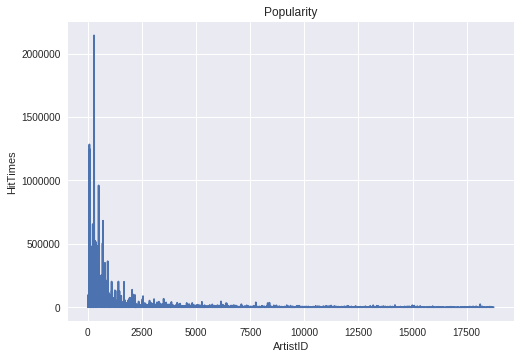

In [31]:
import matplotlib.pyplot as plt
plt.plot(ArtistPopularity.ArtistID,ArtistPopularity.HitTimes)
plt.xlabel('ArtistID')
plt.ylabel('HitTimes')
plt.title('Popularity')

Artists with ArtistID<=2500 are the most popular. The following gives the ranking of Artists from the most popular to the least popular. Artists 289,72,89,292,498 are the top 5 most popular artists.

In [44]:
ArtistPopularity.sort_values(by=['HitTimes'],ascending=False)

,ArtistID,HitTimes
283,289,2143837.0
66,72,1283763.0
83,89,1245613.0
286,292,1045616.0
492,498,960446.0
61,67,897815.0
282,288,873934.0
695,701,682104.0
221,227,655560.0
294,300,527910.0


It seems like a lot of artists have only one hit. This could mean that the top artists have most of the fans(users) in the dataset.

In [0]:
ArtistPopularityRanked = ArtistPopularity.sort_values(by=['HitTimes'],ascending=False)

A total of 68438134 hits is recorded.

In [46]:
np.sum(ArtistPopularityRanked.HitTimes)

68438134.0

The top 100 artists out of 17374 artists have >43.36% of total hits.

In [47]:
np.sum(ArtistPopularityRanked.head(100).HitTimes)/np.sum(ArtistPopularityRanked.HitTimes)

0.433682923032355

The top 200 artists out of 17374 artists have >53.63% of total hits.

In [48]:
np.sum(ArtistPopularityRanked.head(200).HitTimes)/np.sum(ArtistPopularityRanked.HitTimes)

0.5363655005555821

## Collaborative Filtering

### Read the user_friends dataframe.

In [49]:
user_friends = pd.read_table('gdrive/My Drive/Project2/hetrec2011-lastfm-2k/user_friends.dat', sep='\t', header=None, skiprows=1)
user_friends = user_friends.rename(index = int, columns={0: "UserID", 1: "FriendID"})
user_friends.head()

,UserID,FriendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


### Recommend favorite artists of friends to the user.

The friends() function returns the friends of a user.

In [50]:
def friends(uid):
    return user_friends.loc[user_friends['UserID']==uid]
friends(5)

,UserID,FriendID
30,5,228
31,5,725
32,5,831
33,5,1271
34,5,1310
35,5,1481
36,5,1785


The initializing function recommendlist_initialize() intializes an empty dataframe consists of three columns: <b>UserID</b>, <b>FriendArtistID</b>(the ArtistID in friends' favorite artists lists), <b>Rate</b>.

In [55]:
def recommendlist_initialize():
    return pd.DataFrame([],columns=['UserID','FriendArtistID','Rate'])
recommendlist_initialize()

,UserID,FriendArtistID,Rate


The friend_artists() function returns a list of all the artists that the friends of a user have listened to.

In [56]:
def friend_artists(uid):
    User_FriendArtists = recommendlist_initialize()##initialization
    for k,v in friends(uid).FriendID.iteritems():
        User_FriendArtists = User_FriendArtists.append(user_artists.loc[user_artists.UserID==v].rename(columns\
                                                 ={'ArtistID':'FriendArtistID'}).replace(v,uid))
        ## Replace friends' UserID by the user's UserID since we do not need the information of which friend listened to which artist
        ## Replace ArtitstID by FriendArtistID since these are the artists that friends has listened to.
    return User_FriendArtists
friend_artists(5).head()

,FriendArtistID,Rate,UA,UserID
10547,197,0.0013,"(228, 197)",5
10548,212,0.0017,"(228, 212)",5
10549,219,0.0008,"(228, 219)",5
10550,222,0.0008,"(228, 222)",5
10551,609,0.0018,"(228, 609)",5


The function recommendedtop(n,uid) returns the top n artists evaluated by the sum of weights that the user's friends have listened to.

In [58]:
def recommendedtop(n,uid):
    recommended = friend_artists(uid).groupby(['FriendArtistID'])['Rate'].sum().sort_values(ascending\
                                              =False).to_frame().reset_index().FriendArtistID.head(n)
    return recommended
recommendedtop(10,5)

0      154
1     2524
2     7650
3     1520
4      207
5       57
6      173
7     9233
8      190
9    12168
Name: FriendArtistID, dtype: int64

### Accuracy

The accuracy(n,uid) function checks the number of artists who are simultaneously in the top-n recommended list and in the top-n of a user's favorite artists list. The accuracy is calculated by this number divided by n.  

In [0]:
def accuracy(n,uid):
    Correct =0
    RealTop = user_artists.loc[user_artists.UserID==uid].ArtistID.head(n)
    for k_rec,rec in recommendedtop(n,uid).iteritems():
        for k_real,real in RealTop.iteritems():
             if rec == real:
                Correct += 1
    Accuracy = Correct/n
    return Accuracy

The accuracy of predicting Top-10 artists of User 5.

In [60]:
accuracy(10,5)

0.3

Visualize the accuracies of predicting Top 1<=n<=50 artists of User 5.

Text(0.5, 1.0, 'Accuracy v.s Top 50')

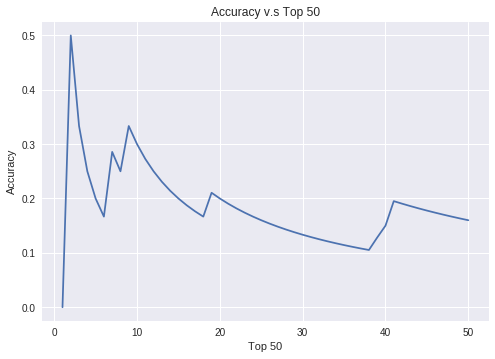

In [62]:
x = np.arange(1,51)
y = [accuracy(n,uid=5) for n in x]
plt.plot(x,y)
plt.xlabel('Top 50')
plt.ylabel('Accuracy')
plt.title('Accuracy v.s Top 50')

## Content-Based Recommendation

We want to see the predictive power of our recommendation system on unseen data. To do this, we separate the user_artists dataframe into a training set(60%), a validation set(20%), and a test set(20%). We first use the training set to initialize the recommendation matrix by SVD. Secondly, we use SGD to minimize the MSE of the training and validation set combined. Finally we evaluate the accuracy.

We separate the "user_artists_majority" dataframe into 60% train_data, 20% of validation data and 20% of test_data

In [0]:
train_data = user_artists_majority.sample(frac=0.6, random_state=0)#randomly select 60%
none_train_data = user_artists_majority.loc[~user_artists_majority.index.isin(train_data.index)]#the rest 40% is in none_train data
validation_data = none_train_data.sample(frac=0.5, random_state=0)#50% of none_train data is stored in validation data.
test_data = none_train_data.loc[~none_train_data.index.isin(validation_data.index)]#the remaining 50% of none_train data is stored in test data. 
len(user_artists_majority)==len(train_data)+len(validation_data)+len(test_data)

True

The train_data and the validation_data combined is called the none_test_data.

In [0]:
none_test_data = train_data.append(validation_data)
none_test_data.head()

,UserID,ArtistID,Rate,UA
42587,939,2619,0.0540,"(939, 2619)"
36462,798,10095,0.0127,"(798, 10095)"
37152,814,1048,0.0155,"(814, 1048)"
75723,1708,2537,0.1030,"(1708, 2537)"
72973,1647,1388,0.0150,"(1647, 1388)"


Create a sparse pivot table with users in rows and items in columns using train_data.

In [0]:
R_svd_init = user_artists_majority.pivot(index='UserID', columns='ArtistID', values='Rate').fillna(0)
R_svd_init.shape

(1829, 17374)

R_svd_init is not a zero matrix.

In [0]:
R_svd_init.loc[665,1061]

0.0073

Replace the data in the initial recommendation matrix that are not in train_data by 0. The initial infomation we have is the train_data.

In [0]:
for (uid,artid), r_ui in list(zip(none_train_data.UA, none_train_data.Rate)):
          R_svd_init.at[uid, artid] = 0

Test if the data not in train_data has been replaced.

The value at (2,53) has been modified to 0 since (2,53) is NOT in train_data

In [0]:
R_svd_init.at[2, 53]  

0.0

In [0]:
none_train_data.UA.head()

2     (2, 53)
4     (2, 55)
7     (2, 58)
10    (2, 61)
13    (2, 64)
Name: UA, dtype: object

The value at (2,51) has not been modified to 0 since (2,51) is in train_data

In [0]:
R_svd_init.at[2, 51]  

1.3883

In [0]:
train_data[train_data.UA==(2,51)]

,UserID,ArtistID,Rate,UA
0,2,51,1.3883,"(2, 51)"


Now we initialize the component matrices P and Q based on train_data. Remember the R_svd_init matrix only contains information of train_data.

In [0]:
t = time.time()
R_svd_init_matrix = R_svd_init.as_matrix()
from scipy.sparse.linalg import svds
NUMBER_OF_FACTORS = 50
U, sigma, V = svds(R_svd_init_matrix, k = NUMBER_OF_FACTORS)
P = np.matmul(U,np.sqrt(np.diag(sigma)))
Q = np.matmul(np.sqrt(np.diag(sigma)),V)
elapsed = time.time()-t
print("processed time is %.1f s" % elapsed)

processed time is 8.6 s


Save copies of P and Q.

In [0]:
P_Copy = P.copy()
Q_Copy = Q.copy()

Construct the recommendation matrix from P and Q, called R0.

In [0]:
R0 = pd.DataFrame(data=np.matmul(P_Copy,Q_Copy),dtype=float,columns=np.sort(user_artists_majority.ArtistID.unique()))
R0['UserID'] = np.sort(user_artists_majority.UserID.unique())
cols = R0.columns.tolist()
cols = cols[-1:] + cols[:-1]
R0 = R0[cols].set_index('UserID')
R0.head()

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
UserID,,,,,,,,,,,,,,,,,,,,,
2,-5.714411e-05,-8.468154e-06,-2.889242e-08,0.0,-2.231605e-05,-1.668987e-04,0.004073,-8.984354e-06,-5.109797e-04,-4.329410e-07,...,0.0,-6.051253e-07,-4.408770e-07,0.0,-3.457859e-07,0.0,0.0,0.0,-3.090461e-07,5.076018e-06
3,-2.852036e-09,2.399163e-08,1.214145e-10,0.0,1.866258e-08,4.571437e-08,0.000001,2.136604e-07,3.693935e-07,2.181458e-09,...,0.0,1.522301e-09,1.109105e-09,0.0,8.698863e-10,0.0,0.0,0.0,7.774609e-10,3.815592e-08
4,6.266569e-05,1.020025e-05,1.002129e-08,0.0,4.233396e-06,9.422825e-06,0.000092,-1.577129e-06,7.418232e-04,4.732593e-07,...,0.0,6.624041e-07,4.826087e-07,0.0,3.785166e-07,0.0,0.0,0.0,3.382992e-07,1.178174e-05
5,1.554788e-06,1.147693e-05,3.407899e-08,0.0,9.125044e-06,3.647488e-05,0.000334,4.432612e-05,1.914981e-04,6.364766e-07,...,0.0,6.353649e-07,4.629087e-07,0.0,3.630657e-07,0.0,0.0,0.0,3.244899e-07,2.027153e-05
6,-1.153957e-08,-2.101944e-07,-2.307123e-10,0.0,-1.416418e-07,-7.156654e-07,-0.000004,-4.760587e-08,-3.950208e-07,-1.579358e-08,...,0.0,-1.036271e-09,-7.549972e-10,0.0,-5.921546e-10,0.0,0.0,0.0,-5.292382e-10,-7.797641e-08


Store dataframe versions of  P and Q with index.

In [0]:
P = pd.DataFrame(data=P,dtype=float,index=R0.index)
Q = pd.DataFrame(data=Q,dtype=float,columns=R0.columns)

In [0]:
P.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
UserID,,,,,,,,,,,,,,,,,,,,,
2,-0.003635,-1.144434e-04,-0.000656,0.006235,-0.000255,-0.005903,0.005652,0.025670,-0.010613,0.003093,...,2.855138e-04,2.389976e-04,3.636634e-02,-1.066153e-04,-8.033916e-04,4.901229e-03,-3.609294e-02,-4.310732e-03,2.289810e-05,-4.542762e-03
3,-0.000007,7.511523e-07,0.000012,0.000032,-0.000073,-0.000041,-0.000008,-0.000011,0.000004,0.000013,...,-1.467684e-08,1.361791e-06,3.103477e-08,-1.334519e-08,6.147931e-08,9.726551e-08,-1.426577e-07,-1.858570e-07,1.927478e-08,-6.454451e-09
4,-0.001614,-2.002709e-04,-0.003162,0.006448,-0.015996,-0.006991,-0.001889,-0.000072,-0.000502,-0.000752,...,-4.328403e-05,-4.326253e-05,-1.659315e-03,-6.279901e-05,-2.750566e-03,-1.189679e-02,-1.103034e-01,-1.534018e-03,1.619732e-05,-6.823619e-04
5,-0.004784,-2.305348e-04,-0.001812,0.014611,-0.028912,-0.015558,-0.003195,-0.004926,0.002901,0.003939,...,-3.464513e-05,2.935022e-04,8.672029e-05,-8.706369e-05,4.125154e-04,7.632759e-05,-6.906504e-04,-1.081303e-04,1.094327e-05,-3.024611e-05
6,-0.000170,1.854065e-06,0.000015,-0.000016,-0.000011,0.000071,-0.000049,0.000182,0.000074,-0.000081,...,2.651194e-08,1.835684e-08,-8.563902e-07,1.701462e-06,-5.099017e-06,2.017481e-05,-3.731967e-06,-1.003633e-05,1.343285e-08,-2.711616e-07


In [0]:
Q.head()

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
0,0.000022,8.161663e-04,8.548840e-07,0.0,0.000466,0.002143,0.092973,0.001131,0.000372,8.668665e-05,...,0.0,-1.333880e-06,-9.718269e-07,0.0,-7.622172e-07,0.0,0.0,0.0,-6.812316e-07,-0.000148
1,0.000006,-3.221301e-06,1.104487e-08,0.0,-0.000003,-0.000018,-0.000185,0.000032,-0.000113,-2.070906e-07,...,0.0,-7.822778e-08,-5.699453e-08,0.0,-4.470159e-08,0.0,0.0,0.0,-3.995204e-08,-0.000008
2,0.000024,1.056511e-04,2.534261e-06,0.0,0.000068,0.000125,0.024976,0.007465,-0.000560,2.237172e-05,...,0.0,3.401319e-07,2.478104e-07,0.0,1.943611e-07,0.0,0.0,0.0,1.737102e-07,0.000031
3,-0.000297,3.709107e-07,6.056801e-07,0.0,0.000039,0.000263,0.004767,0.001058,0.001413,6.636449e-06,...,0.0,-1.479865e-05,-1.078187e-05,0.0,-8.456371e-06,0.0,0.0,0.0,-7.557881e-06,0.000040
4,-0.000079,-2.107457e-04,-8.382669e-07,0.0,-0.000069,-0.000233,-0.005533,-0.001330,-0.004498,-2.204030e-05,...,0.0,-1.985688e-05,-1.446716e-05,0.0,-1.134679e-05,0.0,0.0,0.0,-1.014119e-05,-0.000077


Calculate the MSE of R0 against the train data.

In [0]:
t = time.time()
MSE_R0_train = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(train_data.UA, train_data.Rate))])
print("The MSE of R0 against the train_data is %.10f" %MSE_R0_train)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the train_data is 644.4244722674
Processed time: 0.7 s


Calculate the MSE of R0 against the validation data.

In [0]:
t = time.time()
MSE_R0_validation = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(validation_data.UA, validation_data.Rate))])
print("The MSE of R0 against the validation_data is %.10f" %MSE_R0_validation)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the validation_data is 3919.7429054224
Processed time: 0.2 s


Calculate the MSE of R0 against the test data.

In [0]:
t = time.time()
MSE_R0_test = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(test_data.UA, test_data.Rate))])
print("The MSE of R0 against the test_data is %.10f" %MSE_R0_test)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the test_data is 2379.8144425020
Processed time: 0.2 s


Calculate the MSE of R0 against the none_test data.

In [0]:
t = time.time()
MSE_R0_none_test = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(none_test_data.UA, none_test_data.Rate))])
print("The MSE of R0 against the none_test_data is %.10f" % MSE_R0_none_test)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the none_test_data is 4564.1673776898
Processed time: 0.9 s


Apply SGD to minimize the MSE against the train_data.

In [0]:
t = time.time()
steps = 1
for _ in range(steps):# Rounds of iterations. We expect each round to reduce the MSE. 
    for (uid,artid), r_ui in list(zip(train_data.UA, train_data.Rate)):                  
      err = r_ui-Q.loc[:,artid]*P.loc[uid,:]#This is the negative of the scaled gradient
      # Update vectors p_u and q_i
      P.loc[uid,:] = P.loc[uid,:]+0.0000001*err*Q.loc[:,artid]
      Q.loc[:,artid] = Q.loc[:,artid]+0.0000001*err*P.loc[uid,:]

elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

Processed time: 105.1 s


In [0]:
P.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
UserID,,,,,,,,,,,,,,,,,,,,,
2,-0.003635,-1.144434e-04,-0.000656,0.006235,-0.000255,-0.005903,0.005652,0.025670,-0.010613,0.003093,...,2.855142e-04,2.389979e-04,3.636635e-02,-1.066155e-04,-8.033930e-04,4.901238e-03,-3.609301e-02,-4.310741e-03,2.289816e-05,-4.542777e-03
3,-0.000007,7.511526e-07,0.000012,0.000032,-0.000073,-0.000041,-0.000008,-0.000011,0.000004,0.000013,...,-1.467687e-08,1.361793e-06,3.103482e-08,-1.334521e-08,6.147942e-08,9.726569e-08,-1.426580e-07,-1.858574e-07,1.927483e-08,-6.454472e-09
4,-0.001614,-2.002709e-04,-0.003162,0.006448,-0.015996,-0.006991,-0.001889,-0.000072,-0.000502,-0.000752,...,-4.328409e-05,-4.326260e-05,-1.659317e-03,-6.279912e-05,-2.750571e-03,-1.189682e-02,-1.103034e-01,-1.534021e-03,1.619736e-05,-6.823641e-04
5,-0.004784,-2.305349e-04,-0.001812,0.014611,-0.028912,-0.015558,-0.003195,-0.004926,0.002901,0.003939,...,-3.464518e-05,2.935026e-04,8.672042e-05,-8.706384e-05,4.125162e-04,7.632773e-05,-6.906517e-04,-1.081306e-04,1.094330e-05,-3.024620e-05
6,-0.000170,1.854066e-06,0.000015,-0.000016,-0.000011,0.000071,-0.000049,0.000182,0.000074,-0.000081,...,2.651198e-08,1.835686e-08,-8.563915e-07,1.701465e-06,-5.099026e-06,2.017485e-05,-3.731974e-06,-1.003636e-05,1.343288e-08,-2.711624e-07


In [0]:
Q.head()

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
0,0.000022,8.161666e-04,8.548843e-07,0.0,0.000466,0.002143,0.092973,0.001131,0.000372,8.668668e-05,...,0.0,-1.333881e-06,-9.718273e-07,0.0,-7.622175e-07,0.0,0.0,0.0,-6.812318e-07,-0.000148
1,0.000006,-3.221302e-06,1.104487e-08,0.0,-0.000003,-0.000018,-0.000185,0.000032,-0.000113,-2.070906e-07,...,0.0,-7.822781e-08,-5.699455e-08,0.0,-4.470161e-08,0.0,0.0,0.0,-3.995206e-08,-0.000008
2,0.000024,1.056511e-04,2.534262e-06,0.0,0.000068,0.000125,0.024976,0.007465,-0.000560,2.237173e-05,...,0.0,3.401320e-07,2.478105e-07,0.0,1.943612e-07,0.0,0.0,0.0,1.737103e-07,0.000031
3,-0.000297,3.709108e-07,6.056804e-07,0.0,0.000039,0.000263,0.004767,0.001058,0.001413,6.636451e-06,...,0.0,-1.479865e-05,-1.078188e-05,0.0,-8.456374e-06,0.0,0.0,0.0,-7.557884e-06,0.000040
4,-0.000079,-2.107458e-04,-8.382672e-07,0.0,-0.000069,-0.000233,-0.005533,-0.001330,-0.004498,-2.204031e-05,...,0.0,-1.985689e-05,-1.446716e-05,0.0,-1.134679e-05,0.0,0.0,0.0,-1.014120e-05,-0.000077


Get the new recommendation matrix R.

In [0]:
R = pd.DataFrame(data=np.matmul(P,Q),dtype=float,columns=np.sort(user_artists_majority.ArtistID.unique()))
R['UserID'] = np.sort(user_artists_majority.UserID.unique())
cols = R.columns.tolist()
cols = cols[-1:] + cols[:-1]
R = R[cols].set_index('UserID')

In [0]:
R.head()

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
UserID,,,,,,,,,,,,,,,,,,,,,
2,-5.714413e-05,-8.468160e-06,-2.889240e-08,0.0,-2.231607e-05,-1.668989e-04,0.004073,-8.984222e-06,-5.109799e-04,-4.329414e-07,...,0.0,-6.051259e-07,-4.408774e-07,0.0,-3.457862e-07,0.0,0.0,0.0,-3.090464e-07,5.076018e-06
3,-2.852037e-09,2.399165e-08,1.214146e-10,0.0,1.866260e-08,4.571442e-08,0.000001,2.136605e-07,3.693939e-07,2.181460e-09,...,0.0,1.522302e-09,1.109106e-09,0.0,8.698870e-10,0.0,0.0,0.0,7.774615e-10,3.815595e-08
4,6.266581e-05,1.020026e-05,1.002130e-08,0.0,4.233400e-06,9.422840e-06,0.000092,-1.577134e-06,7.418244e-04,4.732596e-07,...,0.0,6.624047e-07,4.826092e-07,0.0,3.785170e-07,0.0,0.0,0.0,3.382996e-07,1.178175e-05
5,1.554791e-06,1.147694e-05,3.407902e-08,0.0,9.125053e-06,3.647492e-05,0.000334,4.432616e-05,1.914982e-04,6.364772e-07,...,0.0,6.353654e-07,4.629091e-07,0.0,3.630659e-07,0.0,0.0,0.0,3.244902e-07,2.027154e-05
6,-1.153958e-08,-2.101946e-07,-2.307125e-10,0.0,-1.416419e-07,-7.156659e-07,-0.000004,-4.760606e-08,-3.950212e-07,-1.579359e-08,...,0.0,-1.036272e-09,-7.549979e-10,0.0,-5.921553e-10,0.0,0.0,0.0,-5.292388e-10,-7.797648e-08


Check R has the same index as that of P and the same columns as that of Q.

In [0]:
P.index

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2099, 2100],
           dtype='int64', name='UserID', length=1829)

In [0]:
R.index

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2099, 2100],
           dtype='int64', name='UserID', length=1829)

In [0]:
np.unique(P.index == R.index)

array([ True])

In [0]:
Q.columns

Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
       ...
       18736, 18737, 18738, 18739, 18740, 18741, 18742, 18743, 18744, 18745],
      dtype='object', length=17374)

In [0]:
R.columns

Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
       ...
       18736, 18737, 18738, 18739, 18740, 18741, 18742, 18743, 18744, 18745],
      dtype='object', length=17374)

In [0]:
np.unique(Q.columns == R.columns)

array([ True])

Calculate the MSE of R against the train data.

In [0]:
t = time.time()
MSE_R_train = np.sum([(r_ui - R.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(train_data.UA, train_data.Rate))])
print("The MSE of R against the train_data is %.10f" % MSE_R_train)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R against the train_data is 644.4243710388
Processed time: 0.6 s


In [0]:
MSE_R_train < MSE_R0_train

True

Calculate the MSE of R against the validation data.

In [0]:
t = time.time()
MSE_R_validation = np.sum([(r_ui - R.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(validation_data.UA, validation_data.Rate))])
print("The MSE of R0 against the validation_data is %.10f" % MSE_R_validation)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the validation_data is 3919.7428419252
Processed time: 0.3 s


In [0]:
MSE_R_validation < MSE_R0_validation

True

Calculate the MSE of R against the test data.

In [0]:
t = time.time()
MSE_R_test = np.sum([(r_ui - R.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(test_data.UA, test_data.Rate))])
print("The MSE of R against the test_data is %.10f" % MSE_R_test)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R against the test_data is 2379.8143980665
Processed time: 0.3 s


In [0]:
MSE_R_test < MSE_R0_test

True

Calculate the MSE of R against the none_test data.

In [0]:
t = time.time()
MSE_R_none_test = np.sum([(r_ui - R.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(none_test_data.UA, none_test_data.Rate))])
print("The MSE of R against the none_test_data is %.10f" % MSE_R_none_test)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R against the none_test_data is 4564.1672129640
Processed time: 0.9 s


In [0]:
MSE_R_none_test < MSE_R0_none_test

True

### The Result: After one round of SGD on train_data the MSEs against train_data, validation_data, test_data, none_test_data have all been decreased.

## Next, we include 300 hidden features in SVD. More hidden features lead to lower MSEs agaisnt the train_data. Including dim(R) = min(dim(P),dim(Q)) hidden features gives an MSE of zero. We do not want the model to be overfit though.  

In [0]:
t = time.time()
R_svd_init_matrix = R_svd_init.as_matrix()
from scipy.sparse.linalg import svds
NUMBER_OF_FACTORS = 300
U, sigma, V = svds(R_svd_init_matrix, k = NUMBER_OF_FACTORS)
P = np.matmul(U,np.sqrt(np.diag(sigma)))
Q = np.matmul(np.sqrt(np.diag(sigma)),V)
elapsed = time.time()-t
print("processed time is %.1f s" % elapsed)

processed time is 43.8 s


Store copies of P and Q.

In [0]:
P_Copy = P.copy()
Q_Copy = Q.copy()

Construct the recommendation matrix from P and Q, called R0.

In [0]:
R0 = pd.DataFrame(data=np.matmul(P_Copy,Q_Copy),dtype=float,columns=np.sort(user_artists_majority.ArtistID.unique()))
R0['UserID'] = np.sort(user_artists_majority.UserID.unique())
cols = R0.columns.tolist()
cols = cols[-1:] + cols[:-1]
R0 = R0[cols].set_index('UserID')
R0.head()

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
UserID,,,,,,,,,,,,,,,,,,,,,
2,1.790708e-04,-9.804904e-05,2.549898e-06,0.0,-3.936096e-06,4.035638e-04,-0.000104,0.000016,-0.000258,-4.905154e-05,...,0.0,-0.000038,-2.777176e-05,0.0,-2.178177e-05,0.0,0.0,0.0,-1.946746e-05,-0.000155
3,3.654851e-06,-4.633249e-05,1.130901e-07,0.0,-2.676851e-05,5.755097e-06,0.000012,0.000011,-0.000107,-2.322331e-05,...,0.0,-0.000018,-1.295239e-05,0.0,-1.015874e-05,0.0,0.0,0.0,-9.079370e-06,-0.000001
4,9.420725e-05,2.347450e-04,8.474831e-07,0.0,3.692799e-05,1.017082e-03,0.001212,0.000166,-0.000403,-1.216260e-05,...,0.0,-0.000176,-1.279331e-04,0.0,-1.003397e-04,0.0,0.0,0.0,-8.967862e-05,0.000007
5,1.489520e-05,6.227835e-05,-3.140292e-06,0.0,3.802877e-05,-6.387648e-04,-0.000280,-0.000322,0.002363,-3.395630e-05,...,0.0,0.000094,6.875835e-05,0.0,5.392812e-05,0.0,0.0,0.0,4.819825e-05,0.000084
6,-7.100374e-08,1.971936e-08,2.040378e-08,0.0,3.826354e-07,-8.138383e-09,-0.000048,-0.000005,0.000004,1.635131e-07,...,0.0,0.000001,8.676582e-07,0.0,6.805162e-07,0.0,0.0,0.0,6.082114e-07,-0.000002


In [0]:
t = time.time()
MSE_R0_train = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(train_data.UA, train_data.Rate))])
print("The MSE of R0 against the train_data is %.10f" % MSE_R0_train)
MSE_R0_validation = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(validation_data.UA, validation_data.Rate))])
print("The MSE of R0 against the validation_data is %.10f" % MSE_R0_validation)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the train_data is 69.0766855687
The MSE of R0 against the validation_data is 3934.1921462412
Processed time: 1.7 s


Store the dataframe versions of P and Q with index.

In [0]:
P = pd.DataFrame(data=P,dtype=float,index=R0.index)
Q = pd.DataFrame(data=Q,dtype=float,columns=R0.columns)

In [0]:
P.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
UserID,,,,,,,,,,,,,,,,,,,,,
2,0.001104,0.002223,0.003588,0.006393,-0.000544,-0.000246,-0.008274,-0.003291,-0.001234,-0.001499,...,-2.855138e-04,2.389976e-04,-3.636634e-02,1.066153e-04,8.033916e-04,4.901229e-03,-3.609294e-02,-4.310732e-03,-2.289810e-05,-4.542762e-03
3,-0.000605,-0.000090,0.000317,-0.000215,0.000478,-0.000554,-0.000148,-0.000394,-0.000018,-0.000801,...,1.467685e-08,1.361791e-06,-3.103477e-08,1.334519e-08,-6.147931e-08,9.726551e-08,-1.426577e-07,-1.858570e-07,-1.927478e-08,-6.454451e-09
4,0.003305,0.000097,-0.001595,0.005036,-0.001474,0.004041,0.005272,0.000549,0.001898,0.003993,...,4.328403e-05,-4.326253e-05,1.659315e-03,6.279901e-05,2.750566e-03,-1.189679e-02,-1.103034e-01,-1.534018e-03,-1.619732e-05,-6.823619e-04
5,-0.000448,-0.006762,0.003213,0.003203,-0.000314,0.000540,-0.001113,0.006661,0.004392,0.000922,...,3.464513e-05,2.935022e-04,-8.672029e-05,8.706369e-05,-4.125154e-04,7.632759e-05,-6.906504e-04,-1.081303e-04,-1.094327e-05,-3.024611e-05
6,-0.000191,-0.000256,0.000122,0.000033,-0.000064,0.000040,0.000102,0.000150,0.000016,-0.000068,...,-2.651194e-08,1.835684e-08,8.563902e-07,-1.701462e-06,5.099017e-06,2.017481e-05,-3.731967e-06,-1.003633e-05,-1.343285e-08,-2.711616e-07


In [0]:
Q.head()

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
0,0.000516,0.000425,-0.000022,0.0,-0.000838,-0.009767,-0.010576,-0.001269,-0.009343,-0.000225,...,0.0,0.002327,0.001695,0.0,0.001330,0.0,0.0,0.0,0.001188,-0.000566
1,0.000191,0.004353,0.000035,0.0,0.000549,0.031764,-0.000768,0.000915,0.002669,0.000688,...,0.0,-0.000767,-0.000559,0.0,-0.000438,0.0,0.0,0.0,-0.000392,0.000319
2,0.000686,-0.008545,-0.000002,0.0,-0.004322,-0.008919,-0.016304,-0.008157,-0.034761,-0.002789,...,0.0,0.003955,0.002882,0.0,0.002260,0.0,0.0,0.0,0.002020,0.000971
3,-0.001270,-0.002545,0.000148,0.0,-0.003041,0.030419,-0.000060,-0.003250,-0.018291,0.000052,...,0.0,0.003155,0.002298,0.0,0.001803,0.0,0.0,0.0,0.001611,-0.001074
4,-0.000101,-0.010114,0.000046,0.0,-0.002133,0.008600,0.005465,0.007918,0.008903,-0.002625,...,0.0,-0.006106,-0.004449,0.0,-0.003489,0.0,0.0,0.0,-0.003119,-0.001144


Apply SGD to minimize the MSE against the train_data.

In [0]:
t = time.time()
steps = 10
learning_rate = 0.00000001
for _ in range(steps):# Rounds of iterations. We expect each round to reduce the MSE. 
    for (uid,artid), r_ui in list(zip(train_data.UA, train_data.Rate)):                  
      err = r_ui-Q.loc[:,artid]*P.loc[uid,:]#This is the negative of the scaled gradient
      # Update vectors p_u and q_i
      P.loc[uid,:] = P.loc[uid,:]+learning_rate*err*Q.loc[:,artid]
      Q.loc[:,artid] = Q.loc[:,artid]+learning_rate*err*P.loc[uid,:]

elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

Processed time: 1093.4 s


Get the new recommendation matrix R.

In [0]:
R = pd.DataFrame(data=np.matmul(P,Q),dtype=float,columns=np.sort(user_artists_majority.ArtistID.unique()))
R['UserID'] = np.sort(user_artists_majority.UserID.unique())
cols = R.columns.tolist()
cols = cols[-1:] + cols[:-1]
R = R[cols].set_index('UserID')
R.head()

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
UserID,,,,,,,,,,,,,,,,,,,,,
2,1.790709e-04,-9.804901e-05,2.549899e-06,0.0,-3.936073e-06,4.035637e-04,-0.000104,0.000016,-0.000258,-4.905155e-05,...,0.0,-0.000038,-2.777177e-05,0.0,-2.178178e-05,0.0,0.0,0.0,-1.946746e-05,-0.000155
3,3.654846e-06,-4.633255e-05,1.130898e-07,0.0,-2.676853e-05,5.755053e-06,0.000012,0.000011,-0.000107,-2.322331e-05,...,0.0,-0.000018,-1.295238e-05,0.0,-1.015873e-05,0.0,0.0,0.0,-9.079366e-06,-0.000001
4,9.420737e-05,2.347451e-04,8.474834e-07,0.0,3.692799e-05,1.017082e-03,0.001212,0.000166,-0.000403,-1.216261e-05,...,0.0,-0.000176,-1.279332e-04,0.0,-1.003397e-04,0.0,0.0,0.0,-8.967863e-05,0.000007
5,1.489520e-05,6.227839e-05,-3.140293e-06,0.0,3.802879e-05,-6.387649e-04,-0.000280,-0.000322,0.002363,-3.395630e-05,...,0.0,0.000094,6.875836e-05,0.0,5.392812e-05,0.0,0.0,0.0,4.819826e-05,0.000084
6,-7.100376e-08,1.971946e-08,2.040378e-08,0.0,3.826354e-07,-8.138428e-09,-0.000048,-0.000005,0.000004,1.635131e-07,...,0.0,0.000001,8.676583e-07,0.0,6.805163e-07,0.0,0.0,0.0,6.082115e-07,-0.000002


Check if R has the same index as that of P and the same columns as that of Q.

In [0]:
print(np.unique(P.index == R.index))
print(np.unique(Q.columns == R.columns))

[ True]
[ True]


Check if the MSE against the train_data has been reduced.

In [0]:
t = time.time()
MSE_R0_train = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(train_data.UA, train_data.Rate))])
print("The MSE of R0 against the train_data is %.10f" % MSE_R0_train)
MSE_R_train = np.sum([(r_ui - R.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(train_data.UA, train_data.Rate))])
print("The MSE of R against the train_data is %.10f" % MSE_R_train)
print(MSE_R_train < MSE_R0_train)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the train_data is 69.0766855687
The MSE of R against the train_data is 69.0766721217
True
Processed time: 2.0 s


Check if the MSE against the validation_data has been reduced.

In [0]:
t = time.time()
MSE_R0_validation = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(validation_data.UA, validation_data.Rate))])
print("The MSE of R0 against the validation_data is %.10f" % MSE_R0_validation)
MSE_R_validation = np.sum([(r_ui - R.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(validation_data.UA, validation_data.Rate))])
print("The MSE of R against the validation_data is %.10f" % MSE_R_validation)
print(MSE_R_validation < MSE_R0_validation)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the validation_data is 3934.1921462412
The MSE of R against the validation_data is 3934.1920803078
True
Processed time: 0.6 s


Check if the MSE against the none_test_data has been reduced.

In [0]:
t = time.time()
MSE_R0_none_test = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(none_test_data.UA, none_test_data.Rate))])
print("The MSE of R0 against the none_test_data is %.10f" % MSE_R0_none_test)
MSE_R_none_test = np.sum([(r_ui - R.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(none_test_data.UA, none_test_data.Rate))])
print("The MSE of R against the none_test_data is %.10f" % MSE_R_none_test)
print(MSE_R_none_test < MSE_R0_none_test)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the none_test_data is 4003.2688318099
The MSE of R against the none_test_data is 4003.2687524295
True
Processed time: 1.9 s


Check if the MSE against the test_data has been reduced.

In [0]:
t = time.time()
MSE_R0_test = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(test_data.UA, test_data.Rate))])
print("The MSE of R0 against the test_data is %.10f" % MSE_R0_test)
MSE_R_test = np.sum([(r_ui - R.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(test_data.UA, test_data.Rate))])
print("The MSE of R against the test_data is %.10f" % MSE_R_test)
print(MSE_R_test < MSE_R0_test)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the test_data is 2390.8736537263
The MSE of R against the test_data is 2390.8736081738
True
Processed time: 0.6 s


### Second Approach: We want to replace the none_train data by something more reasonable instead of zeros.

Initialize the recommendation matrix.

In [0]:
R_svd_init = user_artists_majority.pivot(index='UserID', columns='ArtistID', values='Rate').fillna(0)
R_svd_init_matrix = R_svd_init.as_matrix()
R_svd_init.shape

(1829, 17374)

We will check if both train_data and none_train_data contains all users in the user_artists_majority dataframe. Since they are complements of each others, it suffices to check if they have the same list of users. The answer is YES.

In [0]:
np.sort(none_train_data.UserID.unique())

array([   2,    3,    4, ..., 2097, 2099, 2100])

In [0]:
np.sort(train_data.UserID.unique())

array([   2,    3,    4, ..., 2097, 2099, 2100])

In [0]:
np.unique(np.sort(none_train_data.UserID.unique())==np.sort(train_data.UserID.unique()))

array([ True])

Next we find the lowest and highest rate for each user in train_data.

In [0]:
train_data_low_rate = train_data.groupby(['UserID']).Rate.min()
train_data_low_rate = pd.DataFrame(data = train_data_low_rate)
train_data_low_rate.columns=['Low_Rate']
train_data_low_rate.head()

,Low_Rate
UserID,
2,0.1315
3,0.0065
4,0.0221
5,0.0115
6,0.0013


In [0]:
train_data_high_rate = train_data.groupby(['UserID']).Rate.max()
train_data_high_rate = pd.DataFrame(data = train_data_high_rate)
train_data_high_rate.columns=['High_Rate']
train_data_high_rate.head()

,High_Rate
UserID,
2,1.3883
3,1.3176
4,0.4983
5,0.0884
6,0.0040


We will then modify the recommendation matrix by replacing the rates pertain to none_train_data by uniform generated numbers in train_data.

In [0]:
t = time.time()
np.random.seed(42)
for (uid,artid), r_ui in list(zip(none_train_data.UA, none_train_data.Rate)):
          R_svd_init.at[uid, artid] = np.random.uniform(train_data_low_rate.loc[uid,:], train_data_high_rate.loc[uid,:])
elapsed = time.time() - t
print("Processed time is %.1f s" % elapsed)

Processed time is 13.5 s


Generate P and Q and save copies.

In [0]:
from scipy.sparse.linalg import svds
NUMBER_OF_FACTORS = 300
U, sigma, V = svds(R_svd_init_matrix, k = NUMBER_OF_FACTORS)
P = np.matmul(U,np.sqrt(np.diag(sigma)))
Q = np.matmul(np.sqrt(np.diag(sigma)),V)
P_Copy = P.copy()
Q_Copy = Q.copy()

Construct the recommendation matrix from P and Q. Call it R0.

In [0]:
R0 = pd.DataFrame(data=np.matmul(P_Copy,Q_Copy),dtype=float,columns=np.sort(user_artists_majority.ArtistID.unique()))
R0['UserID'] = np.sort(user_artists_majority.UserID.unique())
cols = R0.columns.tolist()
cols = cols[-1:] + cols[:-1]
R0 = R0[cols].set_index('UserID')
R0.head()

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
UserID,,,,,,,,,,,,,,,,,,,,,
2,-0.001160,-0.000895,-2.632605e-05,-4.639531e-05,-8.063736e-04,-0.000877,-0.014065,0.004550,-0.001539,0.000745,...,-0.005854,-0.000461,-0.000336,-0.005263,-0.000264,-0.002126,-0.003615,-0.005112,-0.000236,-0.000174
3,0.000070,-0.000075,-2.336037e-05,-3.635072e-07,1.221710e-05,-0.000053,0.000538,0.000011,-0.000102,0.000022,...,0.000787,0.000062,0.000045,0.000708,0.000035,0.000286,0.000486,0.000688,0.000032,0.000006
4,0.001880,0.003024,-5.896475e-06,-1.183895e-05,3.863184e-04,0.002273,-0.007464,0.032874,0.005107,0.029880,...,0.007361,0.000580,0.000423,0.006618,0.000332,0.002673,0.004546,0.006428,0.000296,0.000277
5,0.000084,-0.000154,-5.415170e-06,-1.681105e-06,4.217794e-05,-0.000257,-0.001477,0.001510,-0.000391,0.003441,...,-0.001612,-0.000127,-0.000093,-0.001449,-0.000073,-0.000585,-0.000996,-0.001408,-0.000065,-0.000022
6,-0.000001,-0.000001,-4.590111e-08,-8.859623e-08,-4.657622e-07,-0.000001,0.000101,0.000020,0.000004,0.000018,...,0.000037,0.000003,0.000002,0.000034,0.000002,0.000014,0.000023,0.000033,0.000002,0.000007


Store the dataframe versions of P and Q with index.

In [0]:
P = pd.DataFrame(data=P,dtype=float,index=R0.index)
Q = pd.DataFrame(data=Q,dtype=float,columns=R0.columns)

In [0]:
P.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
UserID,,,,,,,,,,,,,,,,,,,,,
2,0.018568,0.001604,0.001440,0.001618,0.020371,-0.065341,0.034788,0.042909,-0.008472,-0.001534,...,0.004411,1.804727e-01,-0.009073,0.050276,-0.003760,-5.283766e-04,0.001435,0.023907,-6.694444e-02,-1.572760e-02
3,-0.000664,0.001489,-0.000560,0.002417,-0.001403,0.000175,-0.001958,-0.003548,0.004341,0.000252,...,0.000012,-6.174110e-07,-0.000012,0.000020,-0.000002,1.385971e-07,-0.000001,0.000003,-1.017744e-07,-1.960949e-06
4,-0.025711,0.014746,-0.089739,-0.048739,-0.080983,-0.024482,-0.078045,-0.015875,0.111263,-0.031999,...,-0.016161,4.899302e-02,-0.025779,0.036945,-0.004372,4.315421e-04,-0.002524,0.011645,-9.947156e-03,-5.710281e-03
5,0.003877,0.010395,-0.007128,-0.003566,0.001272,0.003706,0.005435,-0.001369,-0.000690,-0.003905,...,-0.007060,6.035224e-04,-0.001735,0.002921,-0.002300,1.025028e-04,-0.000661,0.000855,-4.126301e-03,-4.996172e-03
6,0.000024,-0.000055,-0.000162,-0.000063,-0.000070,-0.000092,-0.000100,0.000101,0.000022,-0.000281,...,0.000021,2.738843e-06,0.000037,0.000060,-0.000002,-3.337963e-06,-0.000001,0.000024,-4.383502e-07,-4.485815e-07


In [0]:
Q.head()

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
0,-0.000036,0.011224,-0.000038,0.000030,-2.661664e-04,-0.003679,0.060639,0.064212,0.015046,0.003043,...,-0.072679,-0.005728,-0.004173,-0.065345,-0.003273,-0.026391,-0.044889,-0.063465,-0.002926,0.000073
1,0.012806,-0.020108,0.000297,0.000046,3.756975e-04,0.000942,0.044424,0.120806,-0.016301,0.001717,...,-0.057924,-0.004565,-0.003326,-0.052079,-0.002609,-0.021033,-0.035776,-0.050580,-0.002332,-0.000463
2,-0.001821,0.004478,0.000011,0.000053,-7.977490e-04,0.000925,-0.009554,0.002315,-0.001502,-0.013395,...,-0.036366,-0.002866,-0.002088,-0.032696,-0.001638,-0.013205,-0.022461,-0.031755,-0.001464,0.000161
3,0.003869,0.003394,0.000042,0.000071,-3.892506e-04,0.002651,0.005424,0.040055,-0.001651,0.009799,...,-0.017355,-0.001368,-0.000997,-0.015604,-0.000782,-0.006302,-0.010719,-0.015155,-0.000699,-0.000550
4,0.009271,0.018179,0.000013,-0.000126,-9.231277e-07,-0.002616,0.005717,0.072200,0.018714,-0.001780,...,-0.012712,-0.001002,-0.000730,-0.011429,-0.000573,-0.004616,-0.007851,-0.011100,-0.000512,-0.000281


Apply SGD to minimize the MSE against the none_test_data. (We initialize by only using train_data so as not to overfit and the target of machine learning is to minimize MSE against none_test_data.)

In [0]:
t = time.time()
steps = 10
learning_rate = 0.00000001
for _ in range(steps):# Rounds of iterations. We expect each round to reduce the MSE. 
    for (uid,artid), r_ui in list(zip(none_test_data.UA, none_test_data.Rate)):                  
      err = r_ui-Q.loc[:,artid]*P.loc[uid,:]#This is the negative of the scaled gradient
      # Update vectors p_u and q_i
      P.loc[uid,:] = P.loc[uid,:]+learning_rate*err*Q.loc[:,artid]
      Q.loc[:,artid] = Q.loc[:,artid]+learning_rate*err*P.loc[uid,:]

elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

Processed time: 1510.9 s


Get the new recommendation matrix R.

In [0]:
R = pd.DataFrame(data=np.matmul(P,Q),dtype=float,columns=np.sort(user_artists_majority.ArtistID.unique()))
R['UserID'] = np.sort(user_artists_majority.UserID.unique())
cols = R.columns.tolist()
cols = cols[-1:] + cols[:-1]
R = R[cols].set_index('UserID')
R.head()

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
UserID,,,,,,,,,,,,,,,,,,,,,
2,-0.001160,-0.000895,-2.632606e-05,-4.639536e-05,-8.063740e-04,-0.000877,-0.014065,0.004550,-0.001539,0.000745,...,-0.005854,-0.000461,-0.000336,-0.005263,-0.000264,-0.002126,-0.003615,-0.005112,-0.000236,-0.000174
3,0.000070,-0.000075,-2.336037e-05,-3.635045e-07,1.221709e-05,-0.000053,0.000538,0.000011,-0.000102,0.000022,...,0.000787,0.000062,0.000045,0.000708,0.000035,0.000286,0.000486,0.000688,0.000032,0.000006
4,0.001880,0.003024,-5.896474e-06,-1.183896e-05,3.863186e-04,0.002273,-0.007464,0.032874,0.005107,0.029880,...,0.007361,0.000580,0.000423,0.006618,0.000332,0.002673,0.004546,0.006428,0.000296,0.000277
5,0.000084,-0.000154,-5.415171e-06,-1.681102e-06,4.217799e-05,-0.000257,-0.001477,0.001510,-0.000391,0.003441,...,-0.001612,-0.000127,-0.000093,-0.001449,-0.000073,-0.000585,-0.000996,-0.001408,-0.000065,-0.000022
6,-0.000001,-0.000001,-4.590112e-08,-8.859631e-08,-4.657623e-07,-0.000001,0.000101,0.000020,0.000004,0.000018,...,0.000037,0.000003,0.000002,0.000034,0.000002,0.000014,0.000023,0.000033,0.000002,0.000007


Check if the MSE against the none_test_data has been reduced.

In [0]:
t = time.time()
MSE_R0_none_test = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(none_test_data.UA, none_test_data.Rate))])
print("The MSE of R0 against the none_test_data is %.10f" % MSE_R0_none_test)
MSE_R_none_test = np.sum([(r_ui - R.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(none_test_data.UA, none_test_data.Rate))])
print("The MSE of R against the none_test_data is %.10f" % MSE_R_none_test)
print(MSE_R_none_test < MSE_R0_none_test)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the none_test_data is 22424.9244153517
The MSE of R against the none_test_data is 22424.7058243978
True
Processed time: 3.4 s


Check if the MSE against the test_data has been reduced.


In [0]:
t = time.time()
MSE_R0_test = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(test_data.UA, test_data.Rate))])
print("The MSE of R0 against the test_data is %.10f" % MSE_R0_test)
MSE_R_test = np.sum([(r_ui - R.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(test_data.UA, test_data.Rate))])
print("The MSE of R against the test_data is %.10f" % MSE_R_test)
print(MSE_R_test < MSE_R0_test)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the test_data is 17415.6912170478
The MSE of R against the test_data is 17415.6489768874
True
Processed time: 0.6 s


Check if the MSE against the train_data has been reduced.

In [0]:
t = time.time()
MSE_R0_train = np.sum([(r_ui - R0.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(train_data.UA, train_data.Rate))])
print("The MSE of R0 against the train_data is %.10f" % MSE_R0_train)
MSE_R_train = np.sum([(r_ui - R.loc[uid,artid])**2 for (uid,artid), r_ui in list(zip(train_data.UA, train_data.Rate))])
print("The MSE of R against the train_data is %.10f" % MSE_R_train)
print(MSE_R_train < MSE_R0_train)
elapsed = time.time() - t
print("Processed time: %.1f s" % elapsed)

The MSE of R0 against the train_data is 108.0695688353
The MSE of R against the train_data is 108.0695312716
True
Processed time: 1.4 s


## Let us see the recommendation list of each user.

In [0]:
pd.DataFrame(R.loc[2,:]).sort_values(by=2,ascending=False)[0:50]

,2
51,1.405743
81,1.374503
55,1.337143
70,1.234232
82,1.131368
52,1.122147
58,1.099471
72,1.020076
54,0.980493
71,0.906154


In [0]:
pd.DataFrame(R.loc[2,:]).sort_values(by=2,ascending=False)[0:50].reset_index().rename(columns={'index':'ArtistID',2:'Rate'})

,ArtistID,Rate
0,51,1.405743
1,81,1.374503
2,55,1.337143
3,70,1.234232
4,82,1.131368
5,52,1.122147
6,58,1.099471
7,72,1.020076
8,54,0.980493
9,71,0.906154


In [0]:
Top_50_Real = set(user_artists_majority[user_artists_majority.UserID==2].ArtistID)

In [0]:
Top_50_Recommended = set(pd.DataFrame(R.loc[2,:]).sort_values(by=2,ascending=False)[0:50].reset_index().rename(columns={'index':'ArtistID',2:'Rate'}).ArtistID)

In [0]:
Top_50_Real - Top_50_Recommended

set()

Write functions to implement the above.

In [0]:
def top_real(number_of_top_artists = 50 , uid = 2):
    return set(user_artists_majority[user_artists_majority.UserID==uid].ArtistID[0:number_of_top_artists])

def top_recommended(number_of_top_artists = 50 , uid = 2):
    return set(pd.DataFrame(R.loc[uid,:]).sort_values(by=uid,ascending=False)[0:number_of_top_artists].reset_index().rename(columns={'index':'ArtistID',uid:'Rate'}).ArtistID)
    
def fail_to_recommend(number_of_top_artists = 50 , uid = 2):
    return top_real(number_of_top_artists ,  uid) - top_recommended(number_of_top_artists , uid)
  

In [0]:
print(fail_to_recommend(50 , uid = 2))

set()

In [0]:
print(fail_to_recommend(50 , uid = 3))

set()

In [0]:
print(fail_to_recommend(50 , uid = 4))
print("The length of the failure set is %d " % len(fail_to_recommend(50 , uid = 4)))

{153, 156, 158, 160, 165, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 53, 183, 185, 188, 192, 65, 77}
The length of failure set is 25 


In [0]:
print(fail_to_recommend(50 , uid = 5))
print("The length of failure set is %d " % len(fail_to_recommend(50 , uid = 5)))

{53, 194, 197, 200, 201, 202, 204, 205, 211, 212, 213, 214, 215, 216, 218, 219, 223, 224, 232, 233, 235, 236}
The length of failure set is 22 


In [0]:
print(fail_to_recommend(50 , uid = 5))
print("The length of failure set is %d " % len(fail_to_recommend(50 , uid = 50)))

{53, 194, 197, 200, 201, 202, 204, 205, 211, 212, 213, 214, 215, 216, 218, 219, 223, 224, 232, 233, 235, 236}
The length of failure set is 20 


In [0]:
print(fail_to_recommend(50 , uid = 100))
print("The length of failure set is %d " % len(fail_to_recommend(50 , uid = 100)))

{2580, 278, 1958, 171, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2488, 2616, 2490, 712, 215, 859, 1376, 1633, 2533, 1639}
The length of failure set is 24 


In [0]:
print(fail_to_recommend(50 , uid = 1500))
print("The length of failure set is %d " % len(fail_to_recommend(50 , uid = 1200)))

{389, 6150, 9, 3466, 1422, 1295, 6544, 18, 1298, 10902, 1303, 3481, 156, 3613, 32, 3110, 172, 175, 15033, 15034, 13882, 1468, 15035, 15036, 15037, 15038, 15039, 15040, 15041, 15042, 15043, 10310, 9162, 715, 728, 2265, 9433, 1121, 7142, 6760, 7157, 2935, 12668}
The length of failure set is 23 


In [0]:
print(fail_to_recommend(50 , uid = 1500))
print("The length of failure set is %d " % len(fail_to_recommend(50 , uid = 1500)))

{389, 6150, 9, 3466, 1422, 1295, 6544, 18, 1298, 10902, 1303, 3481, 156, 3613, 32, 3110, 172, 175, 15033, 15034, 13882, 1468, 15035, 15036, 15037, 15038, 15039, 15040, 15041, 15042, 15043, 10310, 9162, 715, 728, 2265, 9433, 1121, 7142, 6760, 7157, 2935, 12668}
The length of failure set is 43 


In [0]:
print(fail_to_recommend(50 , uid = 1800))
print("The length of failure set is %d " % len(fail_to_recommend(50 , uid = 1800)))

{6785, 13187, 1029, 6547, 3868, 5149, 5534, 298, 174, 1326, 4024, 4025, 11194, 4036, 4038, 968, 10703, 5072, 8144, 2130, 8784, 16725, 16726, 16727, 16728, 16729, 5978, 16730, 16731, 16732, 6878, 16733, 16734, 16735, 16736, 16737, 16738, 16739, 1020, 1405}
The length of failure set is 40 
